In [2]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import LambdaLR

### Load Data

In [5]:
df = pd.read_csv("./Students_Grading_Dataset.csv")
# df

# for att in df:
#     print(f"{att}: {df[att][0]}")

## Manually select Cols (attribute)

In [6]:

unimportant_attribute = ['Student_ID', 'First_Name', 'Last_Name', 'Email']

filtered_df = df.drop(unimportant_attribute, axis=1)
filtered_df

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,3.99,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,Male,18,Engineering,97.27,97.23,45.80,NaN,94.24,8.32,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,Male,24,Business,57.19,67.05,93.68,67.70,85.70,5.05,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2
3,Female,24,Mathematics,95.15,47.79,80.63,66.06,93.51,6.54,92.12,61.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,Female,23,CS,54.18,46.59,78.89,96.85,83.70,5.97,68.42,66.13,F,15.4,Yes,Yes,High School,High,2,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,Business,NaN,82.15,60.33,80.09,99.32,5.00,58.42,85.21,D,25.5,No,Yes,High School,Low,10,8.3
4996,Male,19,Business,65.11,86.31,49.80,NaN,88.08,2.79,60.87,95.96,C,5.0,No,Yes,NaN,Medium,4,4.0
4997,Female,24,CS,87.54,63.55,64.21,94.28,50.19,3.13,82.65,54.25,A,24.8,Yes,No,High School,Medium,4,6.3
4998,Male,23,CS,92.56,79.79,94.28,81.20,61.18,0.40,94.29,55.84,A,16.1,Yes,Yes,Bachelor's,Low,1,8.4


In [7]:
category_vars = ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']
numerical_vars = list(set(filtered_df.columns) - set(category_vars))

to_do_emb = [1] * len(category_vars) + [0] * len(numerical_vars)
to_do_emb

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Separate rows with-Nan and without-Nan

In [8]:
nan_rows = filtered_df.isna().any(axis=1)

# Nan rows
df_nan = filtered_df[nan_rows]
print(f"row with Nan: {df_nan.shape}")
# Complete rows
df_complete = filtered_df[~nan_rows]
print(f"row without Nan: {df_complete.shape}")

row with Nan: (2419, 19)
row without Nan: (2581, 19)


In [9]:
# split df_complete into train/valid
# data_amount = int(len(df_complete) * 0.8)
# df_train = df_complete.iloc[:data_amount, :]
# df_valid = df_complete.iloc[data_amount:, :]

df_train, df_valid, _, _ = train_test_split(df_complete, df_complete, test_size=0.25, random_state=42)

print(f"df_train: {df_train.shape}")
print(f"df_valid: {df_valid.shape}")

df_train: (1935, 19)
df_valid: (646, 19)


## Preprocessing: 
1. category to numerical
2. max-min norm

In [10]:
def category_to_numerical(data):
    le = LabelEncoder()
    le.fit(data)
    num_data = le.transform(data)
    
    return num_data, le

def max_min_norm(data, train_params = None, process_type = 'train'):
    
    if process_type == 'train':
        data_max = np.max(data)
        data_min = np.min(data)
    else:
        data_max = train_params['Age'][0]
        data_min = train_params['Age'][1]
        
    norm_data = (data - data_min) / (data_max - data_min + 1e-3)    
    
    if process_type == 'train':
        return norm_data, data_max, data_min
    else:
        return norm_data
    
def preprocessing(df, train_params = None, process_type = 'train'):
    
    new_df = pd.DataFrame()
    
    if process_type == 'train':
        train_params = {}
        category_var_len = {}
    
    # # Gender
    # gender = df['Gender']
    # if process_type == 'train':
    #     gender, le = category_to_numerical(gender)
    #     train_params['Gender_le'] = le
    # else:
    #     gender = train_params['Gender_le'].transform(gender)
    # new_df['Gender'] = gender
    
    # # Age
    # age = df['Age']
    # if process_type == 'train':
    #     age, data_max, data_min = max_min_norm(age, process_type = 'train')
    #     train_params['Age'] = [data_max, data_min]
    # else:
    #     age = max_min_norm(age, train_params, process_type = 'valid')
        
    # new_df['Age'] = age.values


    # Category 
    for cat_name in category_vars:
        cat_var = df[cat_name]
        if process_type == 'train':
            cat_var, le = category_to_numerical(cat_var)
            train_params[f'{cat_name}_le'] = le
            category_var_len[f'{cat_name}'] = len(np.unique(cat_var))
        else:
            cat_var = train_params[f'{cat_name}_le'].transform(cat_var)
        new_df[f'{cat_name}'] = cat_var
    
    # Numerical 
    for num_name in numerical_vars:
        num_var = df[num_name]
        if process_type == 'train':
            num_var, data_max, data_min = max_min_norm(num_var, process_type = 'train')
            train_params[num_name] = [data_max, data_min]
        else:
            num_var = max_min_norm(num_var, train_params, process_type = 'valid')
        new_df[num_name] = num_var.values
        
    if process_type == 'train':
        return new_df, train_params, category_var_len
    else:
        return new_df


In [11]:
processed_df_train, train_params, category_var_len = preprocessing(df_train, process_type = 'train')
# train_params
print(f"category_var_len: {category_var_len}")
print(f"processed_df_train: {processed_df_train.shape}")
processed_df_train.head()

category_var_len: {'Gender': 2, 'Department': 4, 'Grade': 5, 'Extracurricular_Activities': 2, 'Internet_Access_at_Home': 2, 'Parent_Education_Level': 4, 'Family_Income_Level': 3}
processed_df_train: (1935, 19)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Quizzes_Avg,Sleep_Hours_per_Night,Stress_Level (1-10),Assignments_Avg,Study_Hours_per_Week,Age,Total_Score,Projects_Score,Final_Score,Midterm_Score,Attendance (%),Participation_Score
0,0,0,1,1,1,0,1,0.578113,0.339932,0.777691,0.335862,0.413638,0.499917,0.234877,0.195635,0.674993,0.290522,0.613510,0.292971
1,1,2,1,1,1,3,1,0.225356,0.299940,0.999889,0.386301,0.361431,0.666556,0.999980,0.265248,0.677994,0.440453,0.946770,0.142986
2,1,0,4,0,1,3,1,0.202720,0.139972,0.333296,0.896900,0.566242,0.499917,0.633147,0.903963,0.725351,0.727973,0.084615,0.115988
3,1,1,4,0,1,1,0,0.920855,0.699860,0.777691,0.686135,0.734910,0.166639,0.985162,0.644716,0.277301,0.471640,0.136225,0.287971
4,1,1,0,0,1,2,2,0.991767,0.279944,0.666593,0.138508,0.261034,0.000000,0.118139,0.039807,0.780044,0.371742,0.257646,0.092991


In [12]:
processed_df_valid = preprocessing(df_valid, train_params, process_type = 'valid')
print(f"processed_df_valid: {processed_df_valid.shape}")
processed_df_valid.head()

processed_df_valid: (646, 19)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Quizzes_Avg,Sleep_Hours_per_Night,Stress_Level (1-10),Assignments_Avg,Study_Hours_per_Week,Age,Total_Score,Projects_Score,Final_Score,Midterm_Score,Attendance (%),Participation_Score
0,0,2,2,0,1,0,1,13.459423,-1.516414,-2.832861,7.818697,1.783036,0.833194,11.488085,13.542743,5.459090,8.838527,7.548742,-2.281286
1,0,2,3,0,1,3,1,9.023496,-2.066322,-2.332945,13.221130,-0.416597,0.833194,11.439760,5.340777,11.271455,13.339443,6.722213,-1.608065
2,1,0,0,0,0,3,1,12.379603,-1.866356,-1.833028,13.047825,0.699883,0.499917,7.477087,11.713048,11.853024,13.636061,7.730378,-2.642893
3,0,1,2,0,1,0,1,10.831528,-1.599733,-1.666389,9.508415,-1.499750,0.833194,7.575404,10.739877,4.319280,6.882186,5.992335,-1.618064
4,0,2,1,0,1,1,2,5.907349,-2.332945,-1.833028,8.553574,-1.083153,0.833194,12.246292,7.193801,8.655224,11.313114,12.569572,-2.127979


In [13]:
class TableDataset(Dataset):
    def __init__(self, data):
        self.data = np.array(data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, id):
        dat = self.data[id, :]
        dat = torch.from_numpy(dat)
        return dat

In [14]:
BATCH_SIZE = 256
DROPOUT = 0.3
TRANSFORMER_LAYER = 3
MASK_PROB = 0.05

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = TableDataset(processed_df_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

valid_dataset = TableDataset(processed_df_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [15]:
# category_var_len: {'Gender': 2, 'Department': 4, 'Grade': 5, 
                #    'Extracurricular_Activities': 2, 'Internet_Access_at_Home': 2, 
                #    'Parent_Education_Level': 4, 'Family_Income_Level': 3}


In [ ]:
class Head(nn.Module):
    def __init__(self, ori_hidden_size = 1, num_head = 4):
        super().__init__()
        self.ori_hidden_size = ori_hidden_size
        self.num_head = num_head
        self.up_emb_size = 32
        
        # due to ori_hidden_size = 1, we up-project it first so that we can do multiHead att
        self.up_emb = nn.Linear(ori_hidden_size, self.up_emb_size, bias=False)
        self.down_emb = nn.Linear(self.up_emb_size, ori_hidden_size, bias=False)
        
        # up_emb_size * 3 for qkv
        self.qkv_fn = nn.Linear(self.up_emb_size, self.up_emb_size * 3, bias=False)
        self.proj_qkv = nn.Linear(self.up_emb_size, self.up_emb_size, bias = False)
                
        # other
        self.att_dropout = nn.Dropout(DROPOUT)
        self.down_dropout = nn.Dropout(DROPOUT)
        
    def forward(self, x):
        '''
        num_vars is seq_len in here
        
        ori_hidden_size = 1
        up_emb = 32
        
        '''        
        batch_size, num_vars, _ = x.shape
        
        # up emb: ori_hidden_size -> up_emb_size
        x = self.up_emb(x)

        # qkv: up_emb_size * 3
        x = self.qkv_fn(x) 
        q, k, v = x.split(self.up_emb_size, dim = 2) 
        
        # split head: each shape = [batch_size, num_head, num_vars(seq_len), head_size = 8]
        q = q.view(batch_size, num_vars, self.num_head, self.up_emb_size // self.num_head).transpose(1, 2)
        k = k.view(batch_size, num_vars, self.num_head, self.up_emb_size // self.num_head).transpose(1, 2)
        v = v.view(batch_size, num_vars, self.num_head, self.up_emb_size // self.num_head).transpose(1, 2)
        
        # attention matrix calculation: [batch_size, num_head, num_vars(seq_len), num_vars]
        att = (q @ k.transpose(-2,-1)) * (1 / torch.sqrt(torch.ones([1]).to(device) * k.size(-1)))
        # att = self.modify_att(att)
        att = F.softmax(att, dim = -1)
        att = self.att_dropout(att)
        
        # att matrix * V: [batch_size, num_head, num_vars(seq_len), head_size]
        out = att @ v
        out = out.transpose(1,2).contiguous().view(batch_size, num_vars, self.up_emb_size)
        out = self.proj_qkv(out)
        
        # down emb: up_emb_size -> ori_hidden_size
        out = self.down_emb(out)
        out = self.down_dropout(out)
        
        return out
    
    def modify_att(self, att):
        '''
        att: [batch_size, num_head, num_vars(seq_len), num_vars]
        '''
        
        # print(f"att: {att.shape}")
        # print(f"category_var_len: {len(category_var_len)}")
        
        num_numerical = 12
        num_category = 7 # (7 * 2)
        
        # average rows for category
        att_category = []
        for c_id in range(num_category):
            cate_row = att[:, :, c_id * 2: (c_id + 1)*2, :]
            aggregated_cate_row = torch.mean(cate_row, dim = 2)
            att_category.append(aggregated_cate_row)
            att_category.append(aggregated_cate_row)

        att_category = torch.stack(att_category, dim = 2)
        # print(f"aggreatt_categorygated_cate_row: {att_category.shape}")

        # average cols for numerical
        att_numerical = []
        for n_id in range(num_category): # ([16, 4, 12, 2])
            category_col = att[:, :, -num_numerical:, n_id * 2: (n_id + 1)*2]
            aggregated_category_col = torch.mean(category_col, dim = 3)
            att_numerical.append(aggregated_category_col)
            att_numerical.append(aggregated_category_col)
            # print(f"category_col: {category_col.shape}")
            
        att_numerical = torch.stack(att_numerical, dim = 3)
        att_numerical = torch.cat([att_numerical, att[:, :,  -num_numerical:, -num_numerical:]], dim = 3)

        att = torch.cat([att_category, att_numerical], dim = 2)
        
        return att

In [17]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.c_fc    = nn.Linear(1, 32)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(32, 1)
        self.dropout = nn.Dropout(DROPOUT)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        
        return x

In [18]:
class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()
        self.ln_head = nn.LayerNorm(1)
        self.head = Head()
        self.ln_mlp = nn.LayerNorm(1)
        self.mlp = MLP()
                
    def forward(self, x):
        
        x = x + self.head(self.ln_head(x))
        x = x + self.mlp(self.ln_mlp(x))

        return x

In [19]:
class GPT(nn.Module):
    def __init__(self, layer):
        super().__init__()
        
        self.blocks = nn.ModuleList(Block() for _ in range(layer))
        
    def forward(self, x):
        
        for block in self.blocks:
            x = block(x)
            
        return x

In [ ]:
class tableModel(nn.Module):
    def __init__(self, category_var_len):
        super(tableModel,self).__init__()
        self.num_category_var = len(category_var_len)
        self.num_numerical_var = 12
        self.emb_size = 2
        self.category_dict = category_var_len
        self.batch_size = BATCH_SIZE
        
        # encode category vars
        self.encode_gender = nn.Embedding(category_var_len['Gender'] + 1, self.emb_size)
        self.encode_depart = nn.Embedding(category_var_len['Department'] + 1, self.emb_size)
        self.encode_grade = nn.Embedding(category_var_len['Grade'] + 1, self.emb_size)
        self.encode_activity = nn.Embedding(category_var_len['Extracurricular_Activities'] + 1, self.emb_size)        
        self.encode_internet = nn.Embedding(category_var_len['Internet_Access_at_Home'] + 1, self.emb_size)
        self.encode_parent = nn.Embedding(category_var_len['Parent_Education_Level'] + 1, self.emb_size)        
        self.encode_income = nn.Embedding(category_var_len['Family_Income_Level'] + 1, self.emb_size)  
        
        self.encoders = [self.encode_gender, self.encode_depart, self.encode_grade, self.encode_activity, self.encode_internet,
                        self.encode_parent, self.encode_income]
        
        self.encode_dropout = nn.Dropout(DROPOUT)
        
        # decode category vars
        self.decode_gender = nn.Linear(self.emb_size, category_var_len['Gender'] + 1, bias=False)
        self.encode_gender.weight = self.decode_gender.weight        
        self.decode_depart = nn.Linear(self.emb_size, category_var_len['Department'] + 1, bias=False)
        self.encode_depart.weight = self.decode_depart.weight       
        self.decode_grade = nn.Linear(self.emb_size, category_var_len['Grade'] + 1, bias=False)
        self.encode_grade.weight = self.decode_grade.weight          
        self.decode_activity = nn.Linear(self.emb_size, category_var_len['Extracurricular_Activities'] + 1, bias=False)
        self.encode_activity.weight = self.decode_activity.weight               
        self.decode_internet = nn.Linear(self.emb_size, category_var_len['Internet_Access_at_Home'] + 1, bias=False)
        self.encode_internet.weight = self.decode_internet.weight    
        self.decode_parent = nn.Linear(self.emb_size, category_var_len['Parent_Education_Level'] + 1, bias=False)
        self.encode_parent.weight = self.decode_parent.weight    
        self.decode_income = nn.Linear(self.emb_size, category_var_len['Family_Income_Level'] + 1, bias=False)
        self.encode_income.weight = self.decode_income.weight    
        
        self.decoders = [self.decode_gender, self.decode_depart, self.decode_grade, self.decode_activity, self.decode_internet,
                        self.decode_parent, self.decode_income]
        
        self.decode_dropout = nn.Dropout(DROPOUT)

        
        # transformer
        self.gpt = GPT(layer = TRANSFORMER_LAYER)
        
    # def masking_table(self, x, seed = 42):
        
    #     '''
    #     x = (batch_size, num_var = 19)
    #     '''
        
    #     torch.manual_seed(seed)
    #     if torch.cuda.is_available():
    #         torch.cuda.manual_seed_all(seed)

    #     self.masking_prob = 0.2       

    #     # category masking
    #     category_var = x[:, :self.num_category_var] #(batch_size, num_var = 7)
        
    #     random_cat = torch.rand((self.batch_size, self.num_category_var)).to(device)
    #     masking_cat = random_cat < self.masking_prob
    #     mask_token = torch.tensor([2, 4, 5, 2, 2, 4, 3]).to(device)
    #     mask_token = mask_token.unsqueeze(0).expand_as(category_var)

    #     masked_category_var = torch.where(masking_cat, mask_token, category_var)
        
    #     # category masking
    #     numerical_var = x[:, -self.num_numerical_var:] #(batch_size, num_var = 12)
        
    #     random_numerical = torch.rand((self.batch_size, self.num_numerical_var)).to(device)
    #     masking_numerical = random_numerical < self.masking_prob
    #     mask_token = torch.zeros_like(random_numerical).to(device)
        
    #     masked_numerical_var = torch.where(masking_numerical, mask_token, numerical_var)

    #     masked_x = torch.cat([masked_category_var, masked_numerical_var], dim = 1)

    #     return masked_x
                        
                        
    # category_var_len: {'Gender': 2, 'Department': 4, 'Grade': 5, 
                    #    'Extracurricular_Activities': 2, 'Internet_Access_at_Home': 2, 
                    #    'Parent_Education_Level': 4, 'Family_Income_Level': 3}

    def masking_table(self, x, seed=42):
        """
        x: (batch_size, num_var = 19)
        """
        # Set random seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        self.masking_prob = MASK_PROB 
        device = x.device  # Get the device from input tensor

        # Category masking
        category_var = x[:, :self.num_category_var].long()  # Ensure category_var is integer type
        random_cat = torch.rand_like(category_var, dtype=torch.float, device=device)
        masking_cat = random_cat < self.masking_prob
        mask_token = torch.tensor([2, 4, 5, 2, 2, 4, 3], device=device, dtype=torch.long).expand_as(category_var)

        # Apply mask in-place (avoiding memory allocation overhead)
        masked_category_var = category_var.clone()  # Clone to avoid modifying input
        masked_category_var[masking_cat] = mask_token[masking_cat]

        # Numerical masking
        numerical_var = x[:, -self.num_numerical_var:].float()  # Ensure numerical_var is float type
        random_numerical = torch.rand_like(numerical_var, dtype=torch.float, device=device)
        masking_numerical = random_numerical < self.masking_prob

        masked_numerical_var = numerical_var.clone()  # Clone to avoid modifying input
        masked_numerical_var[masking_numerical] = 0.5  # Directly set masked values to zero

        # Concatenating the masked category and numerical variables
        return torch.cat([masked_category_var, masked_numerical_var], dim=1)
                        
                        
    def forward(self, x):
        '''
        x: [batch_size, 19]
        
        category vars size = 7 --- embedding ---> category vars size = 14
        numerical vars size = 12
        
        x: [batch_size, 14 + 12]
        '''
        
        ''' masking'''
        x = self.masking_table(x)

        ''' Encode category ''' 
        # category vars
        cat_vars = []
        for c_id, encode_fn in zip(range(self.num_category_var), self.encoders):
            emb_c = encode_fn(x[:,c_id].long())
            emb_c = self.encode_dropout(emb_c)
            cat_vars.append(emb_c)
        cat_vars = torch.cat(cat_vars, dim = 1).float() 
        
        # numerical vars
        num_vars = x[:, - self.num_numerical_var:].float()

        # combine category and numerical vars        
        x = torch.cat([cat_vars, num_vars], dim = 1)

        '''
        Transformer
        '''
        x = torch.unsqueeze(x, dim = 2)
        x = self.gpt(x)
        x = torch.squeeze(x, dim = 2)
        
        
        ''' Decode category ''' 
        # split numerical and category
        num_vars = x[:, - self.num_numerical_var:]
        cat_vars = x[:, :self.num_category_var * 2]
        
        # category vars
        decoded_cat_vars = []
        for c_id, decode_fn in zip(range(self.num_category_var), self.decoders):
            emb_c = cat_vars[:, c_id * self.emb_size: (c_id + 1) * self.emb_size]
            c_var = decode_fn(emb_c)
            c_var = self.decode_dropout(c_var)
            decoded_cat_vars.append(c_var)
        

        return num_vars, decoded_cat_vars
    
    def inference(self, x):
        '''
        DO NOT mask during inference
        '''
        ''' masking'''
        x = self.masking_table(x)
        
        # category vars
        cat_vars = []
        for c_id, encode_fn in zip(range(self.num_category_var), self.encoders):
            emb_c = encode_fn(x[:,c_id].long())
            emb_c = self.encode_dropout(emb_c)
            cat_vars.append(emb_c)
        cat_vars = torch.cat(cat_vars, dim = 1).float()

        # numerical vars
        num_vars = x[:, - self.num_numerical_var:].float()

        # combine category and numerical vars        
        x = torch.cat([cat_vars, num_vars], dim = 1)

        '''
        Transformer
        '''
        x = torch.unsqueeze(x, dim = 2)
        x = self.gpt(x)
        x = torch.squeeze(x, dim = 2)
        
        
        ''' Decode category ''' 
        # split numerical and category
        num_vars = x[:, - self.num_numerical_var:]
        cat_vars = x[:, :self.num_category_var * 2]
        
        # category vars
        decoded_cat_vars = []
        for c_id, decode_fn in zip(range(self.num_category_var), self.decoders):
            emb_c = cat_vars[:, c_id * self.emb_size: (c_id + 1) * self.emb_size]
            c_var = decode_fn(emb_c)
            c_var = self.decode_dropout(c_var)
            pred_c = torch.argmax(c_var, dim = -1)
            decoded_cat_vars.append(pred_c)
        
        decoded_cat_vars = torch.stack(decoded_cat_vars, dim = 1)

        pred = torch.cat([decoded_cat_vars, num_vars], dim = 1)

        return pred

In [21]:

train_dataset = TableDataset(processed_df_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)

valid_dataset = TableDataset(processed_df_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)

In [22]:
def linear_warmup_decay_lr(lr_init, lr_final, num_warmup_steps, num_training_steps):
    """
    Returns a lambda function for LambdaLR.
    - lr_init: 初始學習率
    - lr_final: 最終學習率（不是 0）
    - num_warmup_steps: 預熱步數
    - num_training_steps: 總訓練步數
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return current_step / num_warmup_steps  # 線性預熱
        else:
            progress = (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps)
            return (1 - progress) * (1 - lr_final / lr_init) + (lr_final / lr_init)  # 線性衰減到 lr_final
    return lr_lambda

In [23]:
LEARNING_RATE = 1e-3
EPOCHS = 3000


model = tableModel(category_var_len).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), eps=1e-6, weight_decay=0)

scheduler = LambdaLR(optimizer, lr_lambda=linear_warmup_decay_lr(lr_init = LEARNING_RATE, lr_final = LEARNING_RATE * 0.0001, num_warmup_steps = 30, num_training_steps = EPOCHS))


In [24]:
MSE_loss_fn = nn.MSELoss()
CE_loss_fn = nn.CrossEntropyLoss()

def loss_fn(pred_numerical, pred_category, label):
    
    num_numerical = 12
    num_category = 7
    ratio_numerical = num_numerical / (num_numerical + num_category)
    ratio_category = 1 / (num_numerical + num_category)
    
    label_category = label[:, :num_category]
    label_numerical = label[:, -num_numerical:]
    
    total_loss = torch.zeros(1).to(device)
    
    mse_loss = MSE_loss_fn(pred_numerical, label_numerical)
    total_loss += (mse_loss * ratio_numerical)
    
    for i in range(num_category):
        pred = pred_category[i]
        loss = CE_loss_fn(pred, label_category[:, i].long())
        total_loss += (loss * ratio_category)
        
    return total_loss
    

In [25]:

train_LOSS = []
valid_LOSS = []

for epoch in tqdm(range(EPOCHS), desc="iterate epoch"):
    losses = []
    val_losses = []
    
    model.train()
    for data in train_dataloader:
        
        data = data.float().to(device)
        # print(f"data: {data.shape}")
        pred_numerical, pred_category = model(data)
        loss = loss_fn(pred_numerical, pred_category, data)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    losses = np.mean(losses)
    train_LOSS.append(losses)
    
    if epoch % 30 == 0:    
        print(f"epoch: {epoch}, loss: {losses}")
    
    with torch.no_grad():
        model.eval()
        for data in valid_dataloader:
            data = data.float().to(device)
                
            pred_numerical, pred_category = model(data)
            loss = loss_fn(pred_numerical, pred_category, data)
            val_losses.append(loss.item())
            
    val_losses = np.mean(val_losses)
    valid_LOSS.append(val_losses)
    
    if epoch % 30 == 0:    
        print(f"epoch: {epoch}, val_loss: {val_losses}")
        print()
        
        
        
        # pred = model.inference(data)
        
        
    

iterate epoch:   0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 0, loss: 0.4723139964044094


iterate epoch:   0%|          | 1/3000 [00:00<39:45,  1.26it/s]

epoch: 0, val_loss: 1.943771243095398



iterate epoch:   1%|          | 30/3000 [00:12<20:13,  2.45it/s]

epoch: 30, loss: 0.40724771469831467


iterate epoch:   1%|          | 31/3000 [00:12<20:07,  2.46it/s]

epoch: 30, val_loss: 1.9087577263514202



iterate epoch:   1%|          | 32/3000 [00:13<20:30,  2.41it/s]


KeyboardInterrupt: 

/tmp/ipykernel_4023891/2774934369.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


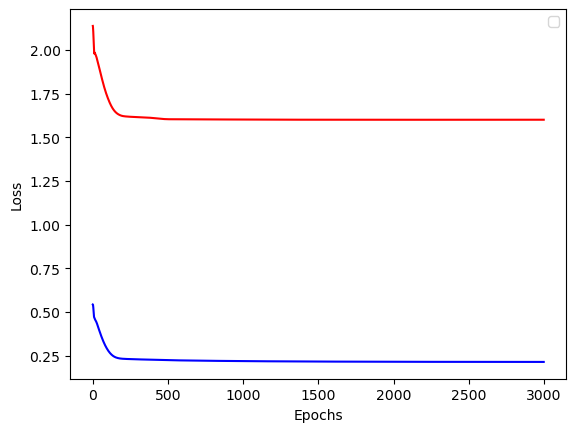

In [ ]:


plt.plot(range(len(train_LOSS)), train_LOSS, color = 'blue')
plt.plot(range(len(valid_LOSS)), valid_LOSS, color = 'red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
from PIL import Image

img = Image.open('../../dataset/train/0.png')

In [30]:
img_np = np.array(img)

In [31]:
img_np.shape

(60, 160, 3)

In [17]:
a = torch.rand((128,128))
a.shape

torch.Size([128, 128])

In [18]:
128 * 128

16384

In [49]:
mean = torch.mean(a)
std = torch.std(a)

outlier_upper = mean + 1 * std
outlier_down = mean - 1 * std

(a < outlier_upper) & (a > outlier_down)

tensor([[ True,  True, False,  ...,  True, False,  True],
        [False,  True, False,  ..., False,  True, False],
        [False, False, False,  ...,  True, False,  True],
        ...,
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False,  True],
        [ True,  True,  True,  ..., False,  True,  True]])

In [26]:
torch.sum(((a < outlier_upper) & (a > outlier_down)))

tensor(9468)

In [53]:
mask = torch.ones((8,8))
causal_mask = torch.tril(mask)
# causal_mask[:8, :8] = float('-inf')
causal_mask

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [54]:
causal_mask = torch.where(causal_mask == 0, float('-inf'), causal_mask)

In [55]:
causal_mask

tensor([[1., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., 1., -inf, -inf, -inf],
        [1., 1., 1., 1., 1., 1., -inf, -inf],
        [1., 1., 1., 1., 1., 1., 1., -inf],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [59]:
c = torch.rand((64, 8,8))
c.shape

torch.Size([64, 8, 8])

In [62]:
d = c * causal_mask
d[0]

tensor([[0.3464,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.7495, 0.4476,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5532, 0.8396, 0.1314,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.9974, 0.1617, 0.9666, 0.8226,   -inf,   -inf,   -inf,   -inf],
        [0.2984, 0.0710, 0.8118, 0.5321, 0.2587,   -inf,   -inf,   -inf],
        [0.2342, 0.8133, 0.4754, 0.8830, 0.8276, 0.8598,   -inf,   -inf],
        [0.9826, 0.2597, 0.8838, 0.6017, 0.3874, 0.0721, 0.6209,   -inf],
        [0.3924, 0.4582, 0.3526, 0.3782, 0.0634, 0.5838, 0.8380, 0.0447]])

In [61]:
e = torch.softmax(d, dim=-1)
e

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5749, 0.4251, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3347, 0.4457, 0.2195,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1036, 0.1849, 0.1319,  ..., 0.1937, 0.0000, 0.0000],
         [0.2117, 0.1027, 0.1917,  ..., 0.0851, 0.1474, 0.0000],
         [0.1218, 0.1300, 0.1170,  ..., 0.1474, 0.1901, 0.0860]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2974, 0.7026, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2228, 0.4092, 0.3680,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1692, 0.1492, 0.2031,  ..., 0.2450, 0.0000, 0.0000],
         [0.1409, 0.1585, 0.1437,  ..., 0.1256, 0.1026, 0.0000],
         [0.1142, 0.1420, 0.0898,  ..., 0.1139, 0.1397, 0.1735]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2951, 0.7049, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3815, 0.2521, 0.3664,  ..., 0.0000, 0.0000, 0.

In [63]:
torch.arange(2)

tensor([0, 1])

In [ ]:
nn.Parameter(torch.rand())